In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Alfa Romeo.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_145,Seri_146,Seri_147,...,Model_2.0 TS Distinctive,Model_2.0 TS Executive,Model_2.0 TS Selespeed,Model_2.0 Turbo,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,252250,-0.636364,1.750000,1.971154,0.524345,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,480000,0.000000,0.083333,0.182692,0.037453,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,375000,-0.181818,1.472222,-0.923077,-0.217228,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,226000,-0.636364,0.500000,0.182692,0.685393,NaN,NaN,0,0,1,...,0,0,0,0,0,0,1,1,0,0
4,439000,0.090909,0.083333,0.182692,0.749064,8.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_4160\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,61574.778574,6.541952e+09,80882.333042,60552.555099


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': [10000],
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:30:32,474] A new study created in memory with name: no-name-9607a78a-8390-4dbe-b22c-747e11428720
[I 2023-05-23 20:30:32,591] Trial 0 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.008442844514789863, 'max_depth': 14, 'min_child_weight': 68}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-23 20:30:32,595] Trial 2 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.003637450186923163, 'max_depth': 10, 'min_child_weight': 263}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-23 20:30:32,606] Trial 1 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.0006243658252771732, 'max_depth': 12, 'min_child_weight': 152}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-23 20:30:32,611] Trial 4 finished with value: 411951.05434637755 and paramete

[I 2023-05-23 20:30:33,473] Trial 29 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.015508508372908592, 'max_depth': 6, 'min_child_weight': 107}. Best is trial 26 with value: 65983.67906789201.
[I 2023-05-23 20:30:33,486] Trial 30 finished with value: 358071.5204502154 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01594310050464956, 'max_depth': 6, 'min_child_weight': 37}. Best is trial 26 with value: 65983.67906789201.
[I 2023-05-23 20:30:33,495] Trial 31 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014902380157646666, 'max_depth': 6, 'min_child_weight': 99}. Best is trial 26 with value: 65983.67906789201.
[I 2023-05-23 20:30:33,516] Trial 32 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014978204278189303, 'max_depth': 5, 'min_child_wei

[I 2023-05-23 20:30:34,845] Trial 59 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.3286117888001854, 'max_depth': 10, 'min_child_weight': 46}. Best is trial 26 with value: 65983.67906789201.
[I 2023-05-23 20:30:34,863] Trial 60 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.2627515585066796, 'max_depth': 8, 'min_child_weight': 47}. Best is trial 26 with value: 65983.67906789201.
[I 2023-05-23 20:30:34,875] Trial 61 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.25024796530971594, 'max_depth': 10, 'min_child_weight': 231}. Best is trial 26 with value: 65983.67906789201.
[I 2023-05-23 20:30:34,910] Trial 62 finished with value: 211940.21771340803 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.2264163903758465, 'max_depth': 10, 'min_child_weigh

[I 2023-05-23 20:30:36,006] Trial 89 finished with value: 76973.92866932822 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.3715094459091686, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 83 with value: 60127.91548126078.
[I 2023-05-23 20:30:36,018] Trial 90 finished with value: 58267.31415142242 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.26013287309318833, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:36,089] Trial 91 finished with value: 60475.53710826013 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.25523287541958445, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:36,199] Trial 92 finished with value: 82381.56727257717 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.2577368089113404, 'max_depth': 4, 'min_child_weight': 29}. B

[I 2023-05-23 20:30:37,393] Trial 118 finished with value: 69053.01740780553 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.23261727501296284, 'max_depth': 5, 'min_child_weight': 8}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:37,487] Trial 121 finished with value: 66487.34407216101 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.22662735372833315, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:37,490] Trial 120 finished with value: 67016.81202110404 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.2234729066933612, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:37,546] Trial 122 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.313684820157513, 'max_depth': 5, 'min_child_weight': 90

[I 2023-05-23 20:30:38,921] Trial 149 finished with value: 78838.65211643325 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.2882547203566857, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:38,922] Trial 150 finished with value: 115034.58674876478 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.26003351906490174, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:38,972] Trial 151 finished with value: 109217.8207382003 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.26075430643094294, 'max_depth': 4, 'min_child_weight': 34}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:39,074] Trial 153 finished with value: 75485.93981593475 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3369713823715901, 'max_depth': 3, 'min_child_weight'

[I 2023-05-23 20:30:40,474] Trial 179 finished with value: 77561.62964872323 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.2190530463434436, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:40,573] Trial 180 finished with value: 73165.22369762331 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.23748494227402434, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:40,628] Trial 181 finished with value: 71712.36993428273 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.24415709186919374, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:40,713] Trial 182 finished with value: 84756.37596862509 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.22974868072303273, 'max_depth': 7, 'min_child_weight'

[I 2023-05-23 20:30:42,407] Trial 208 finished with value: 62423.266974323094 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.408487789384314, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:42,676] Trial 211 finished with value: 75869.88264485897 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.4320149713840756, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:42,714] Trial 210 finished with value: 73077.11905785238 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.442528581313519, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:42,735] Trial 212 finished with value: 70484.58298586044 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.4228033056669842, 'max_depth': 4, 'min_child_weight': 2}. 

[I 2023-05-23 20:30:44,524] Trial 239 finished with value: 63049.91295335992 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.4998982196122951, 'max_depth': 4, 'min_child_weight': 26}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:44,641] Trial 240 finished with value: 60893.632875827076 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.39485304673780036, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:44,712] Trial 241 finished with value: 62111.807699398894 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.3960773128745009, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 90 with value: 58267.31415142242.
[I 2023-05-23 20:30:44,751] Trial 242 finished with value: 70764.4379752513 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.3900547001686562, 'max_depth': 4, 'min_child_weight':

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 58267.3142
Best params:
	colsample_bytree: 0.4
	subsample: 0.8
	learning_rate: 0.26013287309318833
	max_depth: 4
	min_child_weight: 2


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.2, 0.3],
                  "max_depth": [3,4],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.4],
               'subsample': [0.8],
               'min_child_weight': [2]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.4, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 1000, 'subsample': 0.8}
{'TestDeger': 63088.64741789567, 'MSE': 5818093314.884174, 'RMSE': 76276.42699343077, 'MAE': 57111.17598684211}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.8125396561810797

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.4505472681169578

In [16]:
marka_model = joblib.dump(grid_final_model, "Alfa Romeo.pkl")

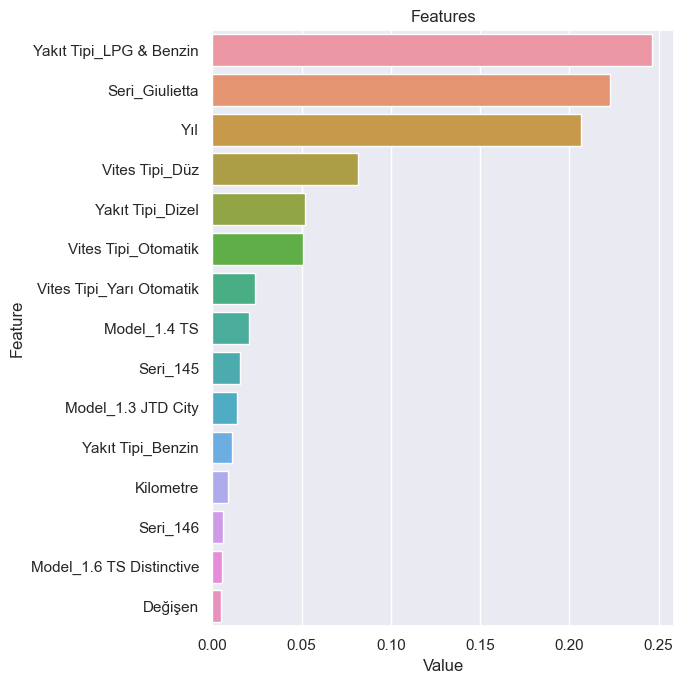

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)